In [36]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

In [10]:
all_data_df = pd.read_csv("Data.csv")
ss = pd.read_csv("SampleSubmission.csv")
weather_data = pd.read_excel("KalamClimateData.xlsx")

In [11]:
# Split 'Source' into 'consumer_device_X' and 'data_user_Y'
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

# Display the updated DataFrame
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device,data_user
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1


In [12]:
# Assuming 'all_data_df' is already defined as in your previous code.
# Convert 'Datetime' column to datetime objects if it's not already
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])

# Extract the date part
all_data_df['Date'] = all_data_df['date_time'].dt.date

# Group by 'Source' and 'Date', then sum the specified columns for each group
aggregated_data = all_data_df.groupby(['Date','Source', 'consumer_device', 'data_user']).agg({
    'kwh': 'sum',
    'v_red': 'sum',
    'current': 'sum',
    'power_factor': 'sum',
    'v_blue': 'sum',
    'v_yellow': 'sum'
}).reset_index()

# Display the aggregated data
aggregated_data.head()

,Date,Source,consumer_device,data_user,kwh,v_red,current,power_factor,v_blue,v_yellow
0,2023-06-24,consumer_device_16_data_user_1,consumer_device_16,1,0.0,398.8,0.0,0.0,0.00,0.00
1,2023-06-24,consumer_device_16_data_user_10,consumer_device_16,10,0.0,398.8,0.0,0.0,0.00,0.00
2,2023-06-24,consumer_device_16_data_user_11,consumer_device_16,11,0.0,0.0,0.0,0.0,396.69,0.00
3,2023-06-24,consumer_device_16_data_user_12,consumer_device_16,12,0.0,0.0,0.0,0.0,0.00,396.69
4,2023-06-24,consumer_device_16_data_user_13,consumer_device_16,13,0.0,398.8,0.0,0.0,0.00,0.00


In [13]:
#set the date as the index
aggregated_data.set_index('Date', inplace=True)

In [14]:
aggregated_data.head()

,Source,consumer_device,data_user,kwh,v_red,current,power_factor,v_blue,v_yellow
Date,,,,,,,,,
2023-06-24,consumer_device_16_data_user_1,consumer_device_16,1,0.0,398.8,0.0,0.0,0.00,0.00
2023-06-24,consumer_device_16_data_user_10,consumer_device_16,10,0.0,398.8,0.0,0.0,0.00,0.00
2023-06-24,consumer_device_16_data_user_11,consumer_device_16,11,0.0,0.0,0.0,0.0,396.69,0.00
2023-06-24,consumer_device_16_data_user_12,consumer_device_16,12,0.0,0.0,0.0,0.0,0.00,396.69
2023-06-24,consumer_device_16_data_user_13,consumer_device_16,13,0.0,398.8,0.0,0.0,0.00,0.00


In [ ]:
# These are the devices that are not in the test SampleSubmission

# devices_to_drop = ["consumer_device_3","consumer_device_5","consumer_device_11", "consumer_device_14",
#                    "consumer_device_15", "consumer_device_17", "consumer_device_24",
#                    "consumer_device_25","consumer_device_27","consumer_device_33","consumer_device_4","consumer_device_9"]

# # Drop the devices that are not in the test SampleSubmission
# aggregated_data = aggregated_data[~aggregated_data['consumer_device'].isin(devices_to_drop)]

In [15]:
aggregated_data.shape

(59728, 9)

In [17]:
#check for duplicated rows across all columns
aggregated_data[aggregated_data.duplicated()]

,Source,consumer_device,data_user,kwh,v_red,current,power_factor,v_blue,v_yellow
Date,,,,,,,,,
2023-06-26,consumer_device_16_data_user_1,consumer_device_16,1,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-26,consumer_device_16_data_user_10,consumer_device_16,10,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-26,consumer_device_16_data_user_11,consumer_device_16,11,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-26,consumer_device_16_data_user_12,consumer_device_16,12,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-26,consumer_device_16_data_user_13,consumer_device_16,13,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-09-23,consumer_device_24_data_user_5,consumer_device_24,5,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-23,consumer_device_24_data_user_6,consumer_device_24,6,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-23,consumer_device_24_data_user_7,consumer_device_24,7,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#check the data type of the index
aggregated_data.index

#convert the index to datetime
aggregated_data.index = pd.to_datetime(aggregated_data.index)

<Axes: xlabel='Date'>

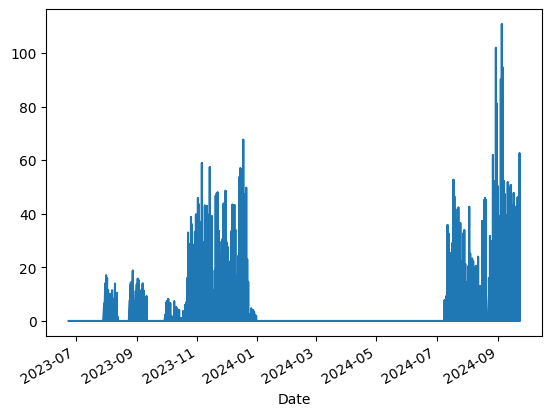

In [ ]:
#plot the kwh column
aggregated_data.kwh.plot()

In [20]:
#calculate statistics of the kwh column
aggregated_data.kwh.describe()

count    59728.000000
mean         0.715074
std          3.928267
min          0.000000
25%          0.000000
50%          0.000000
75%          0.003320
max        110.855212
Name: kwh, dtype: float64

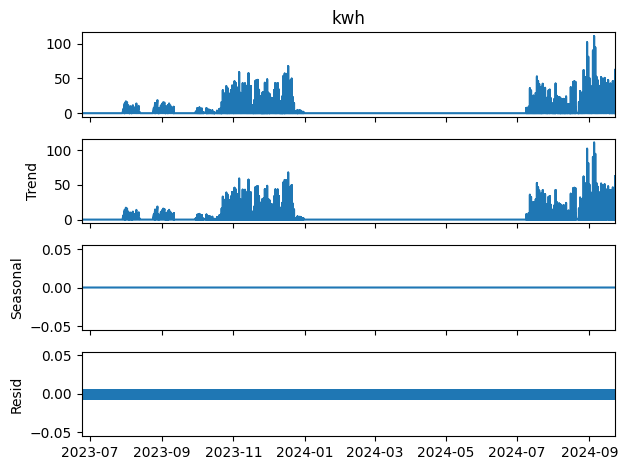

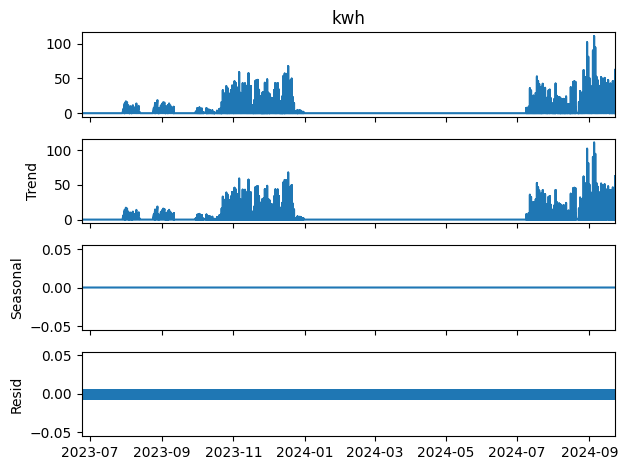

In [ ]:
#decompose the time series
result = seasonal_decompose(aggregated_data.kwh, model='additive', period=1)
result.plot()

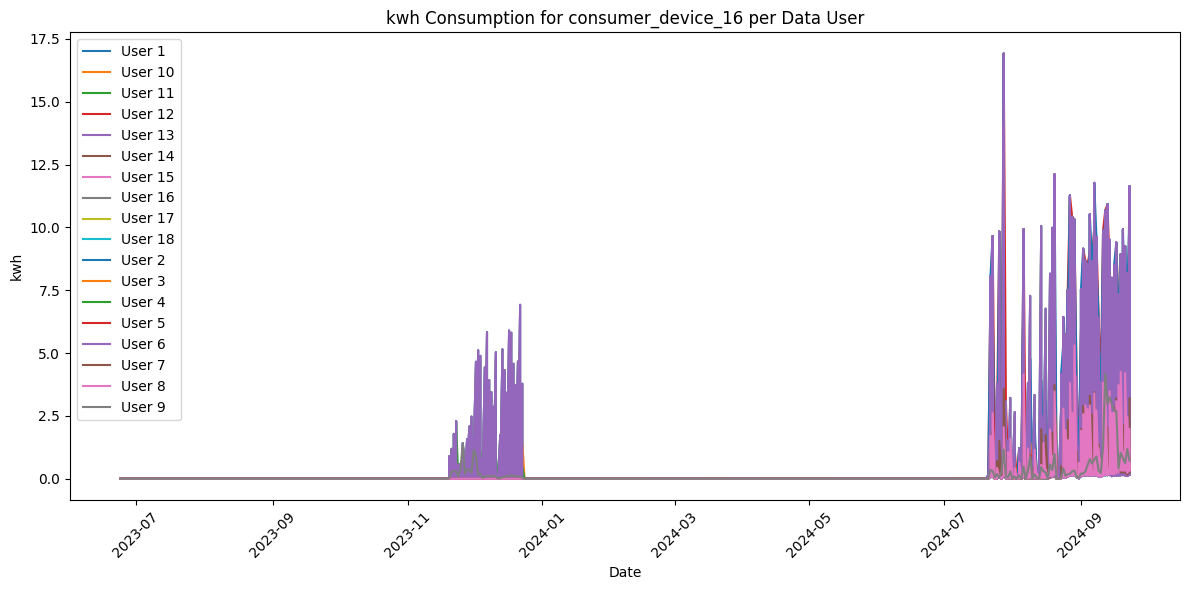

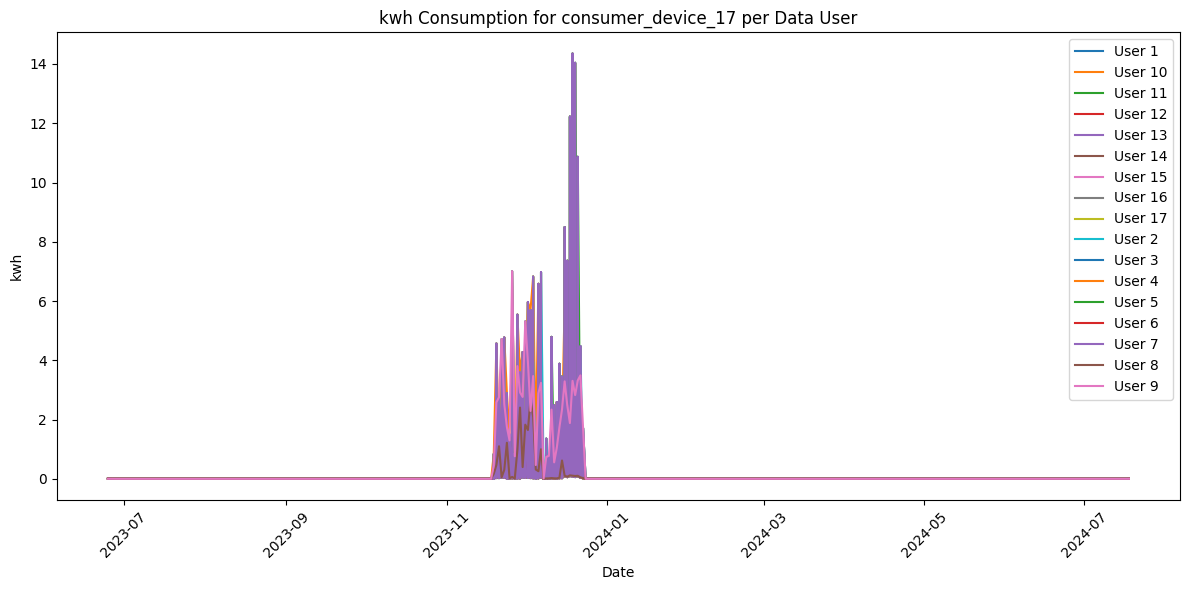

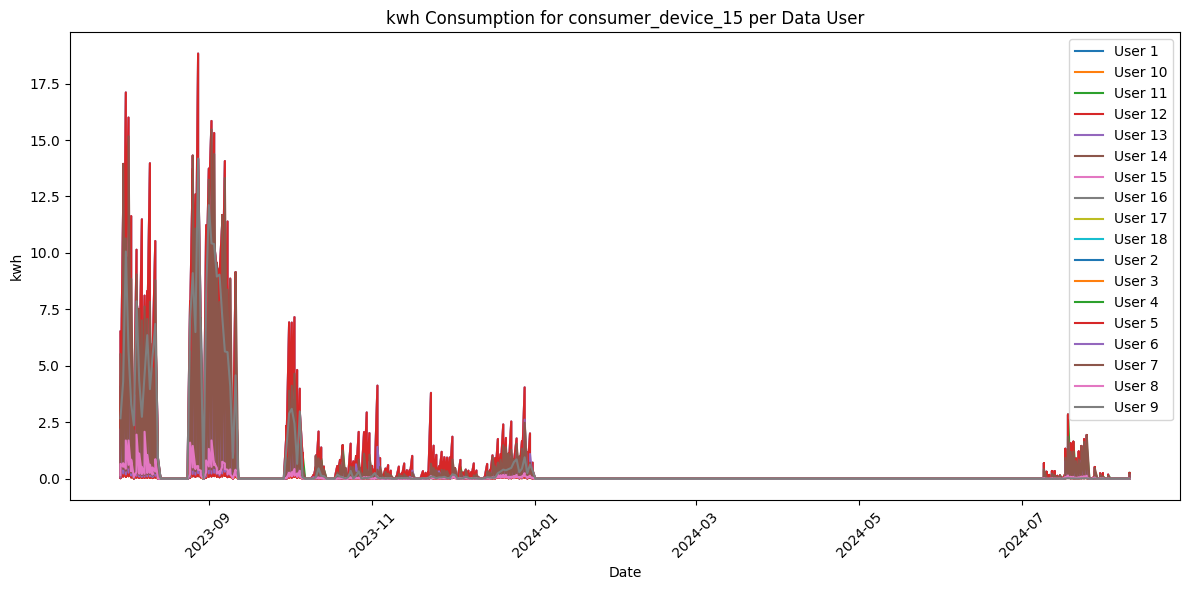

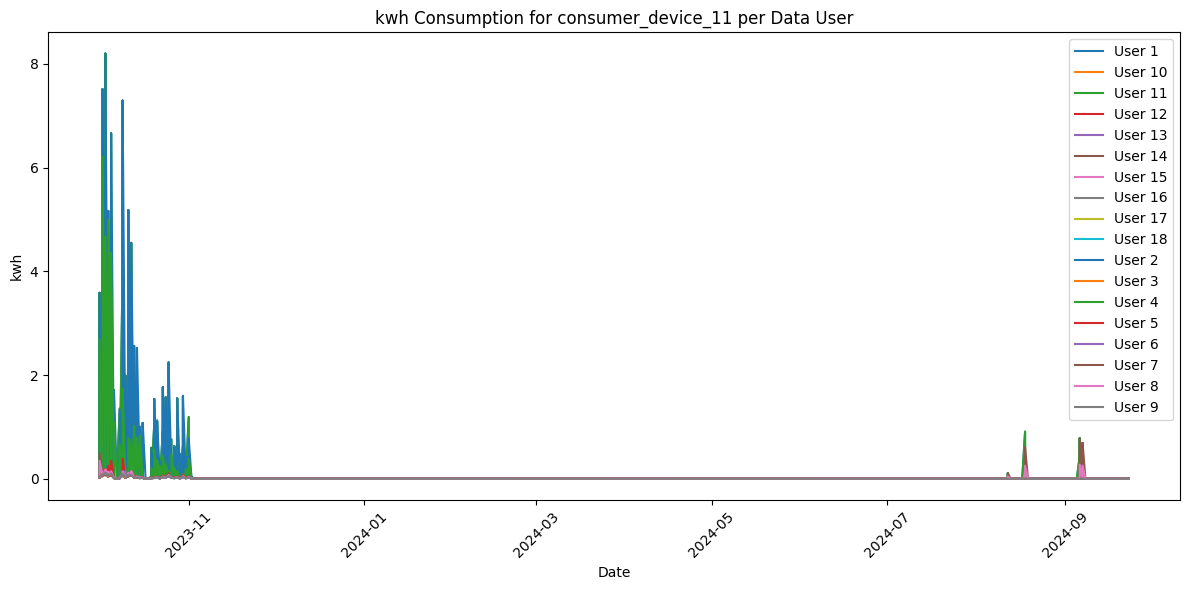

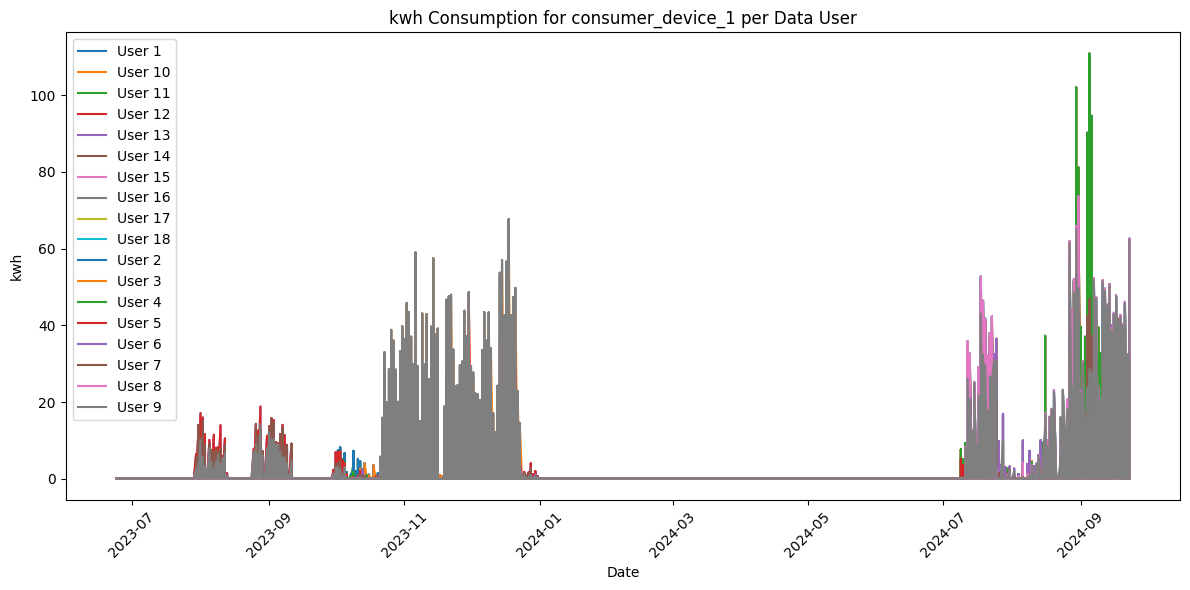

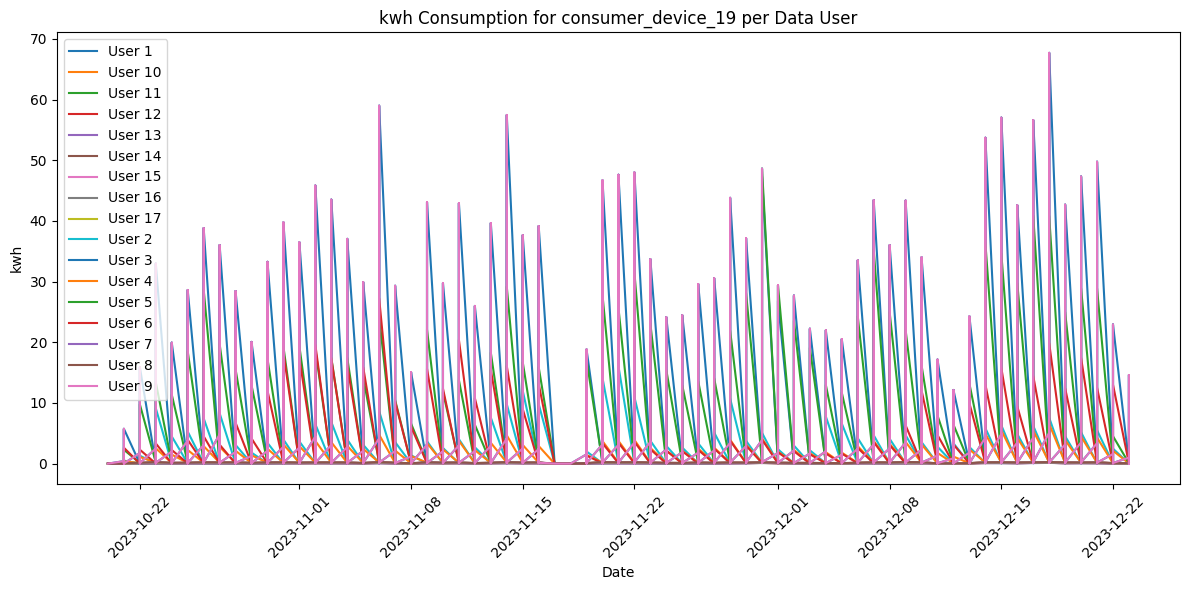

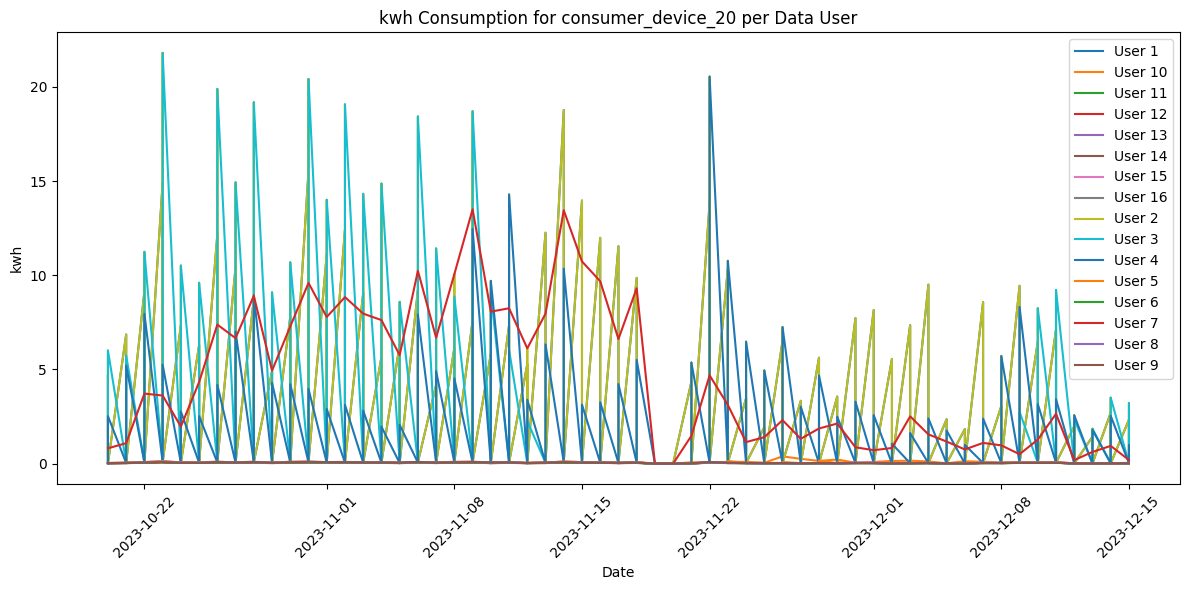

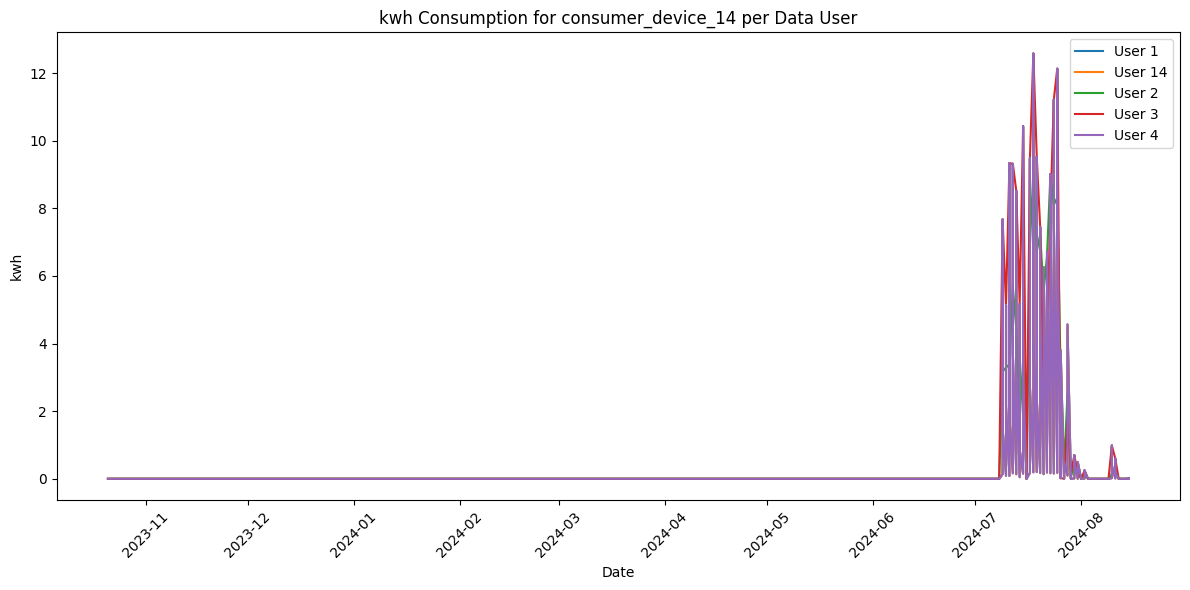

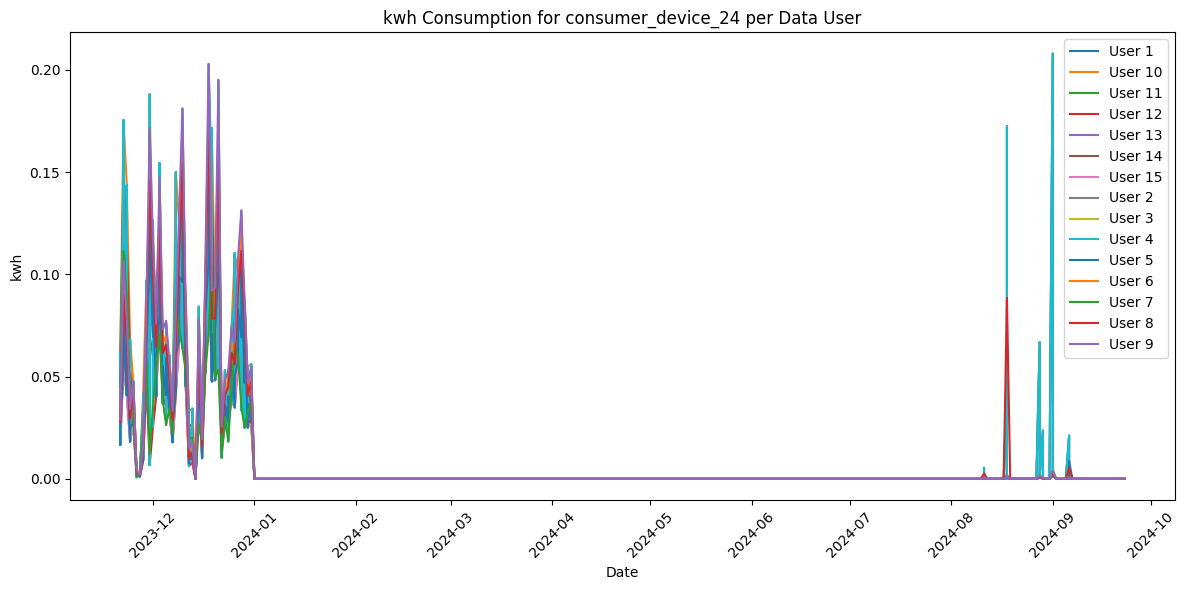

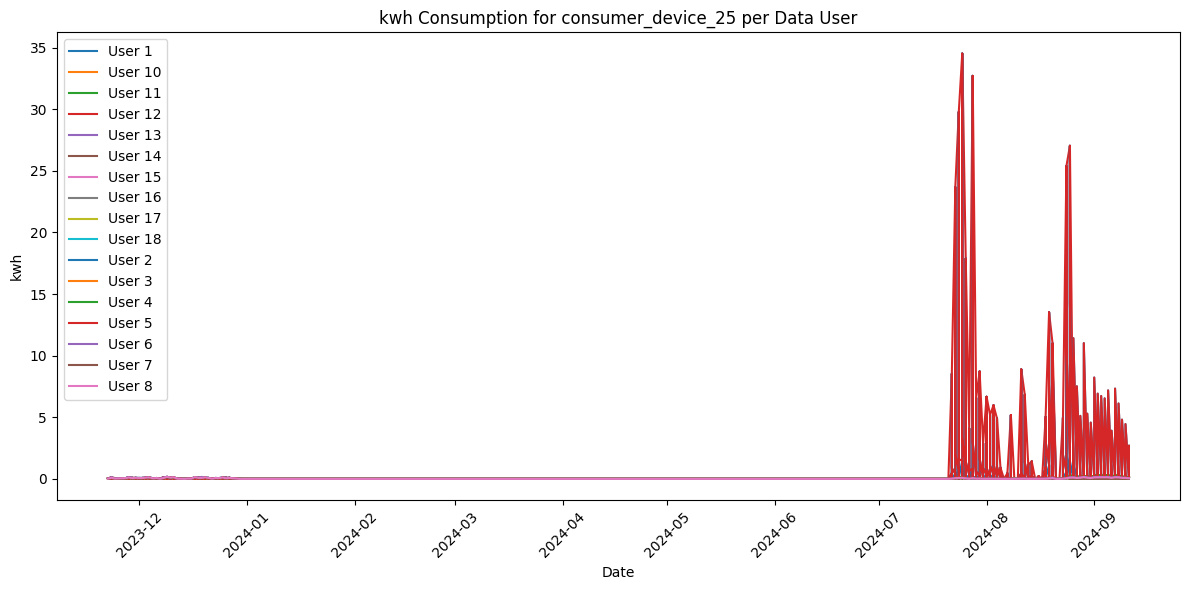

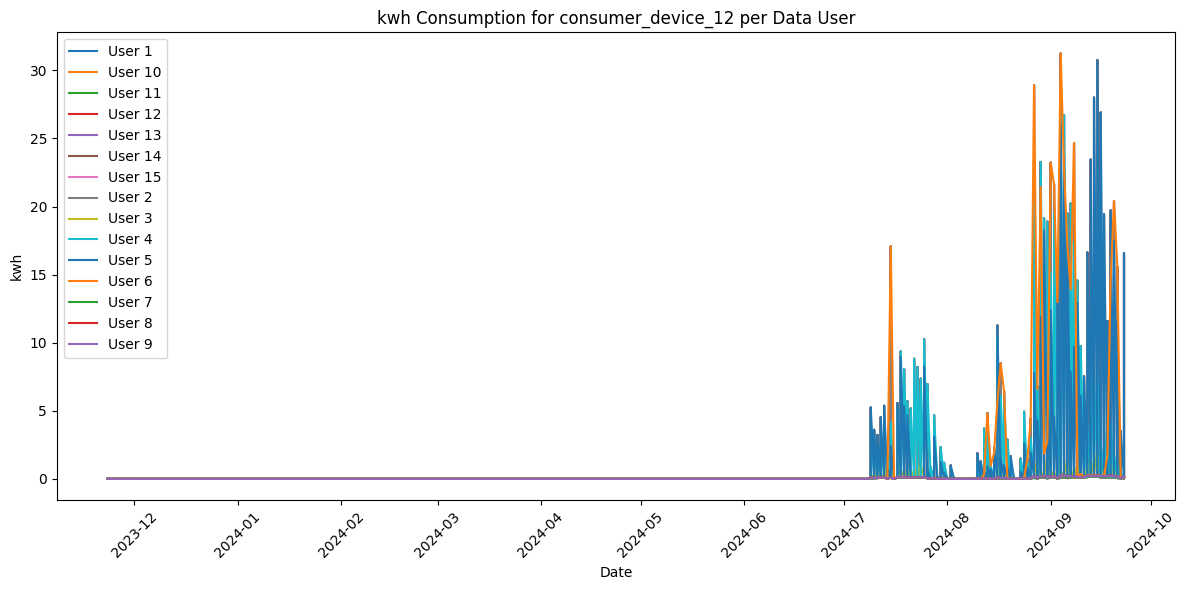

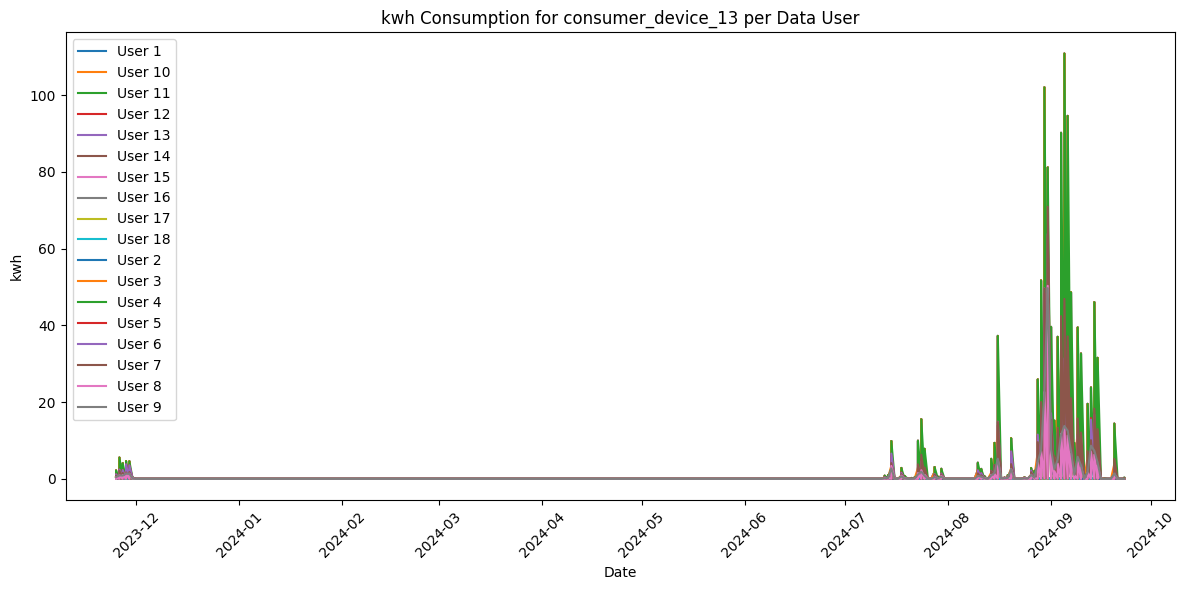

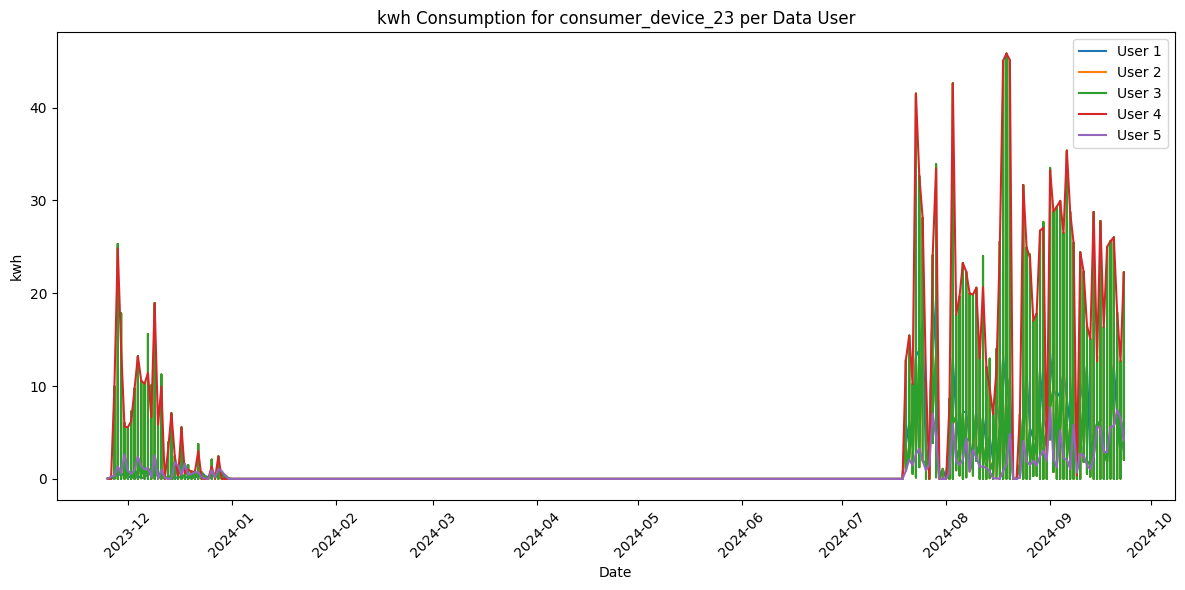

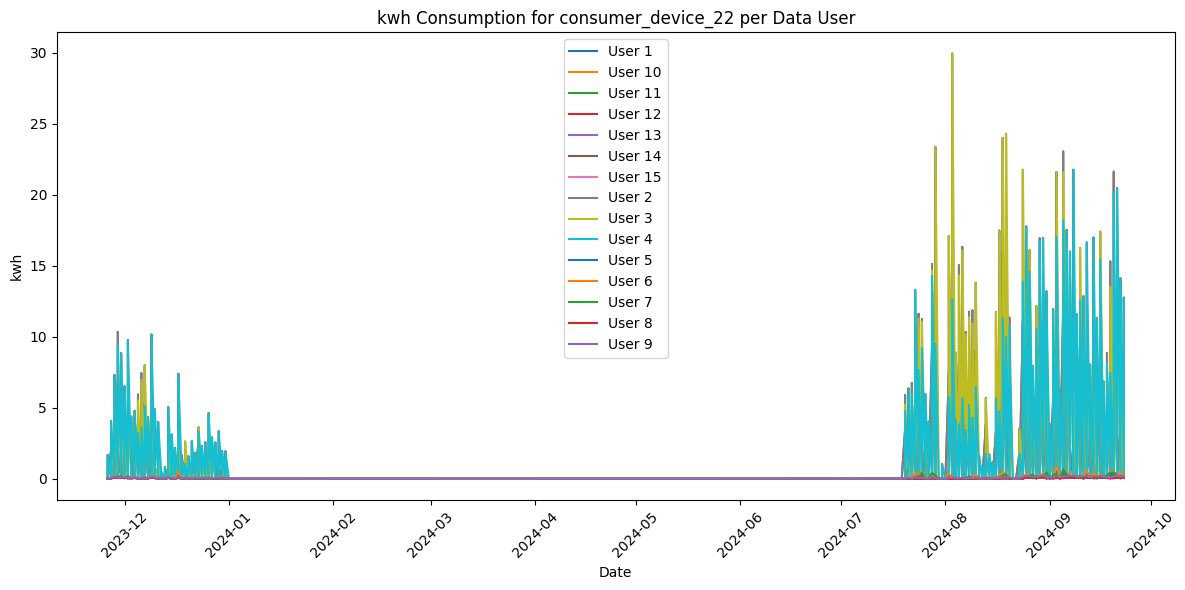

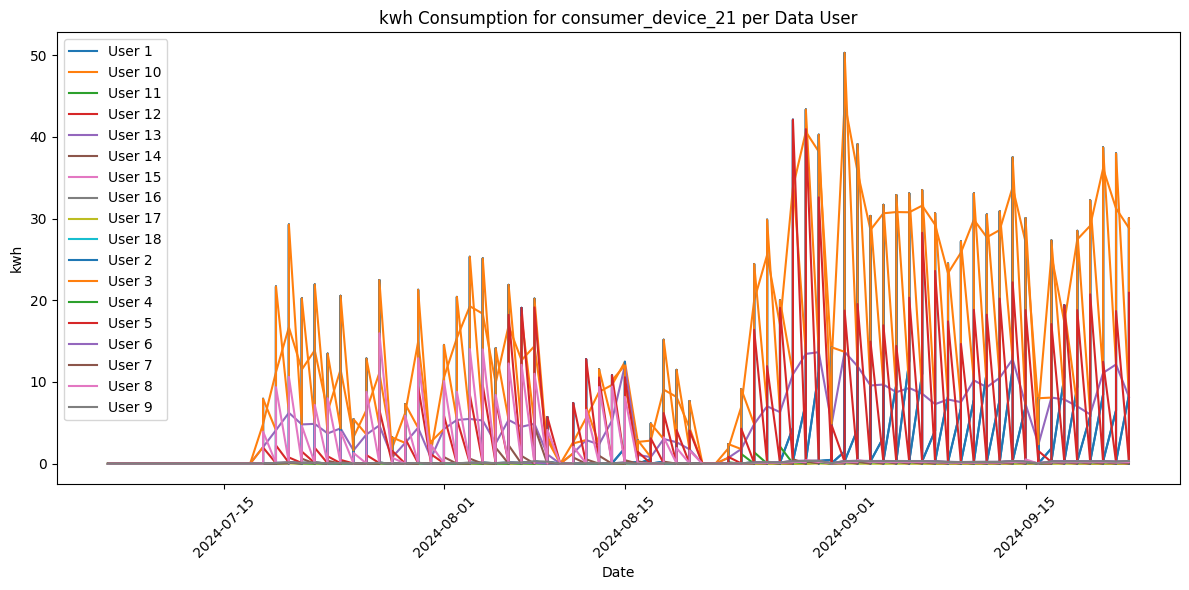

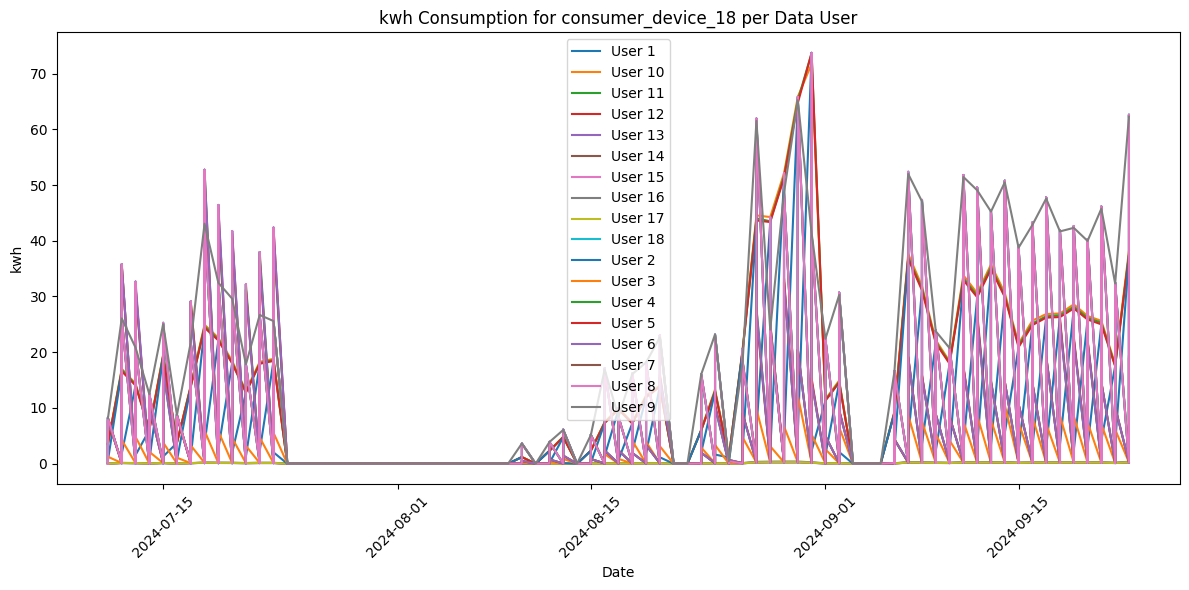

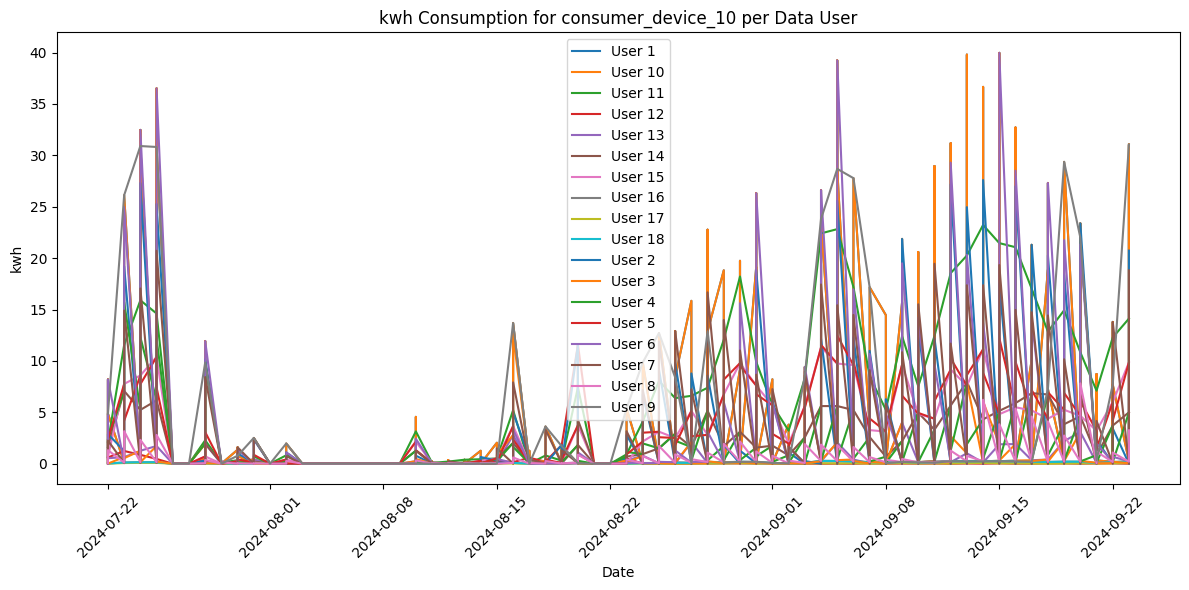

In [30]:
import matplotlib.pyplot as plt

# List of consumer devices and data users
consumer_devices = [
    'consumer_device_16', 'consumer_device_17', 'consumer_device_15',
    'consumer_device_11', 'consumer_device_1', 'consumer_device_19',
    'consumer_device_20', 'consumer_device_14', 'consumer_device_24',
    'consumer_device_25', 'consumer_device_12', 'consumer_device_13',
    'consumer_device_23', 'consumer_device_22', 'consumer_device_21',
    'consumer_device_18', 'consumer_device_10'
]
data_users = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9']

# Loop through each consumer device
for device in consumer_devices:
    # Filter data for the current consumer device
    device_data = aggregated_data[aggregated_data['Source'].str.contains(device)]
    
    # Create a new plot for each consumer device
    plt.figure(figsize=(12, 6))
    
    # Loop through each data user
    for user in data_users:
        # Filter data for the current data user within the current consumer device
        user_data = device_data[device_data['Source'].str.contains(user)]
        
        # Plot the data if it exists for the current user
        if not user_data.empty:
            plt.plot(user_data.index, user_data['kwh'], label=f'User {user}')
    
    # Add labels, title, and legend
    plt.xlabel('Date')
    plt.ylabel('kwh')
    plt.title(f'kwh Consumption for {device} per Data User')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Show the plot for the current consumer device
    plt.show()

In [31]:
#stationary test
from statsmodels.tsa.stattools import adfuller

# Define a function to perform the Augmented Dickey-Fuller test
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    
    # Extract and display test results in a user-friendly manner
    print('Results of Dickey-Fuller Test:')
    df_results = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# Observations Used'])
    for key, value in result[4].items():
        df_results[f'Critical Value ({key})'] = value
    print(df_results)

# Perform the Augmented Dickey-Fuller test on the 'kwh' column
adf_test(aggregated_data['kwh'])

Results of Dickey-Fuller Test:
Test Statistic            -20.087984
p-value                     0.000000
# Lags Used                60.000000
# Observations Used     59667.000000
Critical Value (1%)        -3.430460
Critical Value (5%)        -2.861588
Critical Value (10%)       -2.566796
dtype: float64


### Null and Alternative Hypotheses

- **Null Hypothesis (H₀)**: The time series is **non-stationary** (it has a unit root, meaning it is influenced by trends or seasonality).
- **Alternative Hypothesis (H₁)**: The time series is **stationary** (it does not have a unit root).

### Interpretation of the Results

#### Test Statistic vs. Critical Values:

Your test statistic is **-20.087984**, which is much lower (more negative) than all the critical values:

- **-20.087984 < -3.430460** (1%)
- **-20.087984 < -2.861588** (5%)
- **-20.087984 < -2.566796** (10%)

This means you can **reject the null hypothesis** at all significance levels (1%, 5%, and 10%).

#### p-value:

The p-value is **0.000000**, which is much less than the typical significance level of **0.05** (or even **0.01**).

This provides **strong evidence to reject the null hypothesis**.

#### Conclusion:

Since the test statistic is much lower than the critical values and the p-value is effectively **0**, you can conclude that the time series is **stationary**.

In [34]:
# feature engineering
# Create a new DataFrame to store the features
features = pd.DataFrame()

# Calculate the rolling mean and standard deviation for the 'kwh' column
features['kwh_rolling_mean'] = aggregated_data['kwh'].rolling(window=3).mean()
features['kwh_rolling_std'] = aggregated_data['kwh'].rolling(window=3).std()

In [35]:
features.head(10)

,kwh_rolling_mean,kwh_rolling_std
Date,,
2023-06-24,NaN,NaN
2023-06-24,NaN,NaN
2023-06-24,0.0,0.0
2023-06-24,0.0,0.0
2023-06-24,0.0,0.0
2023-06-24,0.0,0.0
2023-06-24,0.0,0.0
2023-06-24,0.0,0.0
2023-06-24,0.0,0.0


<Figure size 1200x600 with 0 Axes>

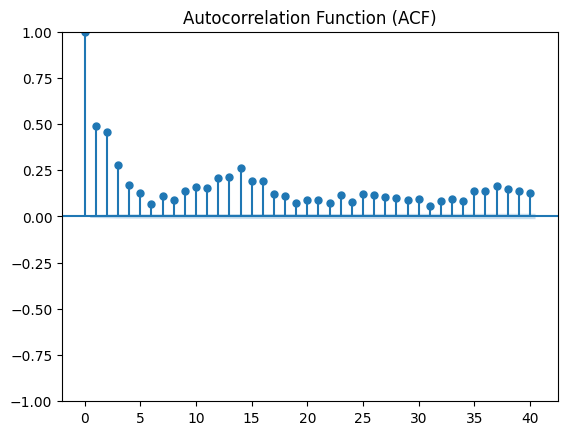

<Figure size 1200x600 with 0 Axes>

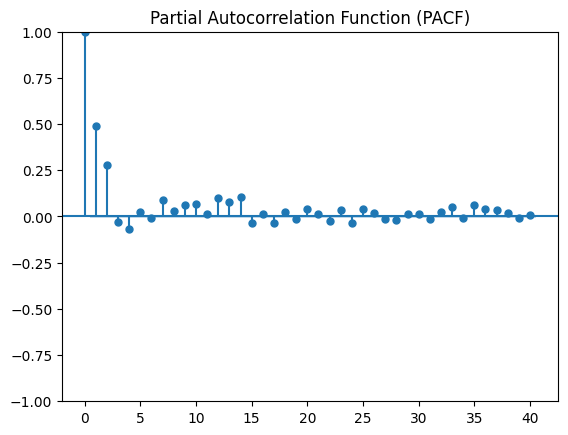

In [37]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(aggregated_data['kwh'], lags=40, title='Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(aggregated_data['kwh'], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()

In [38]:
# Fit ARIMA models with different lag orders and compare AIC/BIC
results = []
for p in range(0, 10):  # Test AR lags from 0 to 9
    model = ARIMA(aggregated_data['kwh'], order=(p, 0, 0))  # ARIMA(p, 0, 0) for AR(p)
    fit = model.fit()
    results.append((p, fit.aic, fit.bic))

# Display results
results_df = pd.DataFrame(results, columns=['p', 'AIC', 'BIC'])
print(results_df)

   p            AIC            BIC
0  0  332943.240030  332961.235143
1  1  316406.627418  316433.620086
2  2  311499.473588  311535.463813
3  3  311447.844222  311492.832003
4  4  311155.275968  311209.261305
5  5  311126.554100  311189.536994
6  6  311124.342009  311196.322458
7  7  310645.998281  310726.976287
8  8  310596.685697  310686.661259
9  9  310359.743730  310458.716848


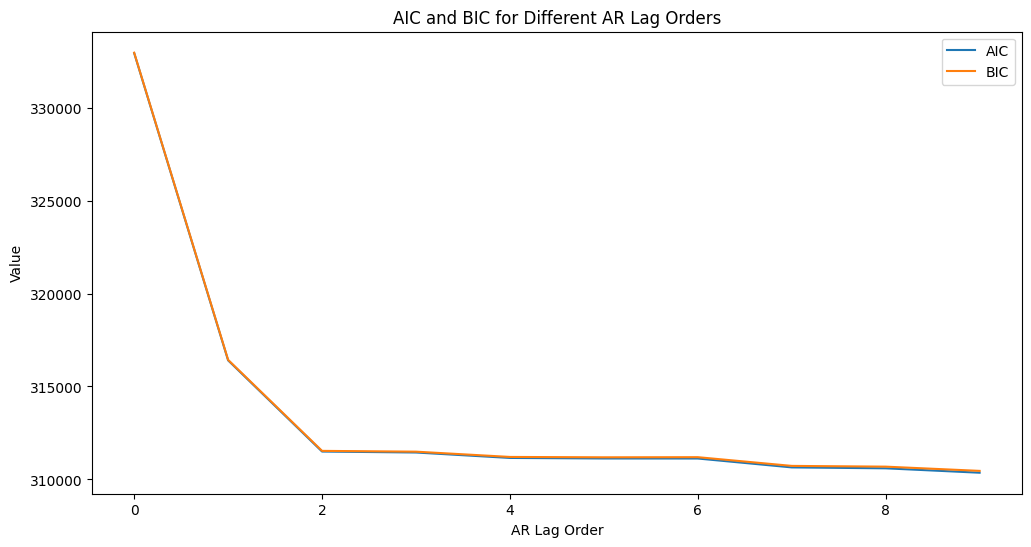

In [39]:
#plot aic and bic values of the result_df in order to determine the best lag order
plt.figure(figsize=(12, 6))
plt.plot(results_df['p'], results_df['AIC'], label='AIC')
plt.plot(results_df['p'], results_df['BIC'], label='BIC')
plt.xlabel('AR Lag Order')
plt.ylabel('Value')
plt.title('AIC and BIC for Different AR Lag Orders')
plt.legend()
plt.show()

**<mark>The lag order of 2 is chosen because the lag decreases for both AIC and BIC insignificantly after order 2.</mark>**

### Why Lag Order 2 is Optimal

#### Diminishing Returns:

- After lag order 2, the reduction in AIC and BIC is minimal, meaning that adding more lags does not significantly improve the model's fit.
- This suggests that **lags beyond 2 do not contribute meaningfully** to explaining the variability in the data.

#### Avoid Overfitting:

- Including too many lags can lead to **overfitting**, where the model captures noise instead of the underlying pattern.
- By stopping at lag order 2, you keep the model **simple and generalizable**.

#### BIC Preference for Simplicity:

- BIC penalizes model complexity more heavily than AIC. If BIC does not improve significantly after lag order 2, it reinforces the decision to stop at 2 lags.

In [40]:
# create lag features using order 2 for the kwh column
features['kwh_lag_1'] = aggregated_data['kwh'].shift(1)
features['kwh_lag_2'] = aggregated_data['kwh'].shift(2)

features.head()

,kwh_rolling_mean,kwh_rolling_std,kwh_lag_1,kwh_lag_2
Date,,,,
2023-06-24,NaN,NaN,NaN,NaN
2023-06-24,NaN,NaN,0.0,NaN
2023-06-24,0.0,0.0,0.0,0.0
2023-06-24,0.0,0.0,0.0,0.0
2023-06-24,0.0,0.0,0.0,0.0


In [41]:
#add holiday indicator here to the feature dataframe, this is parkistan's holiday. use the holiday library to get the dates
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar, nearest_workday, HolidayCalendarFactory
from datetime import date

class PakistanHolidaysCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('Pakistan Day', month=3, day=23),
        Holiday('Labour Day', month=5, day=1),
        Holiday('Independence Day', month=8, day=14),
        Holiday('Quaid-e-Azam Day', month=12, day=25)
    ]

# Create a calendar instance
cal = PakistanHolidaysCalendar()

# Create a date range to check for holidays
date_range = pd.date_range(start=aggregated_data.index.min(), end=aggregated_data.index.max())

# Create a DataFrame with the dates and a column indicating if it's a holiday
holidays = pd.DataFrame(date_range, columns=['Date'])
holidays['Holiday'] = holidays['Date'].isin(cal.holidays()).astype(int)

# Merge the holidays DataFrame with the features DataFrame
features = features.merge(holidays, how='left', left_index=True, right_on='Date').set_index('Date')

features.head()



,kwh_rolling_mean,kwh_rolling_std,kwh_lag_1,kwh_lag_2,Holiday
Date,,,,,
2023-06-24,NaN,NaN,NaN,NaN,0
2023-06-24,NaN,NaN,0.0,NaN,0
2023-06-24,0.0,0.0,0.0,0.0,0
2023-06-24,0.0,0.0,0.0,0.0,0
2023-06-24,0.0,0.0,0.0,0.0,0


In [44]:
#extract on why holiday is 1
features[features['Holiday'] == 1]

,kwh_rolling_mean,kwh_rolling_std,kwh_lag_1,kwh_lag_2,Holiday
Date,,,,,
2023-08-14,0.000000,0.000000,0.000000,0.000000,1
2023-08-14,0.000000,0.000000,0.000000,0.000000,1
2023-08-14,0.000000,0.000000,0.000000,0.000000,1
2023-08-14,0.000000,0.000000,0.000000,0.000000,1
2023-08-14,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...
2024-08-14,0.005373,0.002642,0.008405,0.004145,1
2024-08-14,0.004777,0.003200,0.003569,0.008405,1
2024-08-14,0.002370,0.001193,0.002358,0.003569,1
